In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import uszipcode
from uszipcode import SearchEngine
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import fredapi as fa

In [2]:
df_car = pd.read_csv('used_cars_data.csv')

/home/diegofvargas/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000040 entries, 0 to 3000039
Data columns (total 66 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   vin                      object 
 1   back_legroom             object 
 2   bed                      object 
 3   bed_height               object 
 4   bed_length               object 
 5   body_type                object 
 6   cabin                    object 
 7   city                     object 
 8   city_fuel_economy        float64
 9   combine_fuel_economy     float64
 10  daysonmarket             int64  
 11  dealer_zip               object 
 12  description              object 
 13  engine_cylinders         object 
 14  engine_displacement      float64
 15  engine_type              object 
 16  exterior_color           object 
 17  fleet                    object 
 18  frame_damaged            object 
 19  franchise_dealer         bool   
 20  franchise_make           object 
 21  front_le

## Data Prep

In [4]:
#replace empty values with NaN
df_car = df_car.replace(r'^\s*$', np.nan, regex=True)

In [5]:
(df_car.isnull().sum()/len(df_car)).sort_values(ascending=False)[(df_car.isnull().sum()/len(df_car)).sort_values(ascending=False)>.1]

vehicle_damage_category    1.000000
combine_fuel_economy       1.000000
is_certified               1.000000
bed                        0.993477
cabin                      0.978823
is_oemcpo                  0.954880
is_cpo                     0.939035
bed_height                 0.856969
bed_length                 0.856969
owner_count                0.505664
fleet                      0.475525
theft_title                0.475525
isCab                      0.475525
has_accidents              0.475525
frame_damaged              0.475525
salvage                    0.475525
franchise_make             0.190876
torque                     0.172595
highway_fuel_economy       0.163759
city_fuel_economy          0.163759
power                      0.160473
main_picture_url           0.123029
dtype: float64

In [6]:
#Drop columns that have over 20% of nulls
df_car.drop(['vehicle_damage_category','combine_fuel_economy','is_certified','bed',
             'cabin','is_oemcpo','is_cpo','bed_height','bed_length','owner_count',
             'fleet','theft_title','isCab','has_accidents','frame_damaged','salvage'],
            axis=1, inplace=True)

In [7]:
#Drop columns that don't add predictive power
df_car.drop(['vin','city','description','engine_type','exterior_color','interior_color',
            'franchise_make','listing_id','main_picture_url','major_options','sp_id',
             'sp_name','trimId','trim_name','wheel_system'], axis=1, inplace=True)

In [8]:
df_car.columns

Index(['back_legroom', 'body_type', 'city_fuel_economy', 'daysonmarket',
       'dealer_zip', 'engine_cylinders', 'engine_displacement',
       'franchise_dealer', 'front_legroom', 'fuel_tank_volume', 'fuel_type',
       'height', 'highway_fuel_economy', 'horsepower', 'is_new', 'latitude',
       'length', 'listed_date', 'listing_color', 'longitude', 'make_name',
       'maximum_seating', 'mileage', 'model_name', 'power', 'price',
       'savings_amount', 'seller_rating', 'torque', 'transmission',
       'transmission_display', 'wheel_system_display', 'wheelbase', 'width',
       'year'],
      dtype='object')

In [9]:
#Because of memory issues, need to cut down on categorical values
#For models, I'll keep the ones with a count of at least 10k, the rest will be other. This represents about 2/3 
top_10k_models = df_car.model_name.value_counts()[df_car.model_name.value_counts()>=10000].index.tolist()
df_car['model_name'] = df_car['model_name'].apply(lambda x: 'other' if x not in top_10k_models else x)

In [10]:
#Similarly, will select makers with a count of over 8k, below that seems like there are more rare and luxury cars
top_8k_makers = df_car.make_name.value_counts()[df_car.make_name.value_counts()>=8000].index.tolist()
df_car['make_name'] = df_car['make_name'].apply(lambda x: 'other' if x not in top_8k_makers else x)

In [11]:
#Create numerical values out of strings
df_car['back_legroom'] = df_car['back_legroom'].replace(r'--', np.nan)
df_car['back_legroom'] = df_car['back_legroom'].apply(lambda x: float(x[:-3]) if isinstance(x, str) else x)

In [12]:
#Create numerical values out of strings
df_car['front_legroom'] = df_car['front_legroom'].replace(r'--', np.nan)
df_car['front_legroom'] = df_car['front_legroom'].apply(lambda x: float(x[:-3]) if isinstance(x, str) else x)

In [13]:
#Create numerical values out of strings
df_car['fuel_tank_volume'] = df_car['fuel_tank_volume'].replace(r'--', np.nan)
df_car['fuel_tank_volume'] = df_car['fuel_tank_volume'].apply(lambda x: float(x[:-3]) if isinstance(x, str) else x)

In [14]:
#Create numerical values out of strings
df_car['height'] = df_car['height'].replace(r'--', np.nan)
df_car['height'] = df_car['height'].apply(lambda x: float(x[:-3]) if isinstance(x, str) else x)

In [15]:
#Create numerical values out of strings
df_car['length'] = df_car['length'].replace(r'--', np.nan)
df_car['length'] = df_car['length'].apply(lambda x: float(x[:-3]) if isinstance(x, str) else x)

In [16]:
#Create numerical values out of strings
df_car['maximum_seating'] = df_car['maximum_seating'].replace(r'--', np.nan)
df_car['maximum_seating'] = df_car['maximum_seating'].apply(lambda x: float(x[:-6]) if isinstance(x, str) else x)

In [17]:
#Create numerical values out of strings
df_car['wheelbase'] = df_car['wheelbase'].replace(r'--', np.nan)
df_car['wheelbase'] = df_car['wheelbase'].apply(lambda x: float(x[:-3]) if isinstance(x, str) else x)

In [18]:
#Create numerical values out of strings
df_car['width'] = df_car['width'].replace(r'--', np.nan)
df_car['width'] = df_car['width'].apply(lambda x: float(x[:-3]) if isinstance(x, str) else x)

In [19]:
#Some are negative, need to check why
df_car['listing_age'] = df_car.listed_date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").year) - df_car.year

In [20]:
#Create numerical values out of strings
df_car['power'] = df_car['power'].replace(r'--', np.nan)
df_car['power'] = df_car['power'].apply(lambda x: int(x.replace(',', '').split(' hp')[0]) if isinstance(x, str) else x)

In [21]:
#Create numerical values out of strings
df_car['torque'] = df_car['torque'].replace(r'--', np.nan)
df_car['torque'] = df_car['torque'].apply(lambda x: int(x.replace(',', '').split(' lb-ft')[0]) if isinstance(x, str) else x)

In [22]:
#Code to convert zip code to states and then unto region, to cut down on dimensionality

In [23]:
search = SearchEngine()

In [24]:
states_to_regions = {
    'Washington': 'West', 'Oregon': 'West', 'California': 'West', 'Nevada': 'West',
    'Idaho': 'West', 'Montana': 'West', 'Wyoming': 'West', 'Utah': 'West',
    'Colorado': 'West', 'Alaska': 'West', 'Hawaii': 'West', 'Maine': 'Northeast',
    'Vermont': 'Northeast', 'New York': 'Northeast', 'New Hampshire': 'Northeast',
    'Massachusetts': 'Northeast', 'Rhode Island': 'Northeast', 'Connecticut': 'Northeast',
    'New Jersey': 'Northeast', 'Pennsylvania': 'Northeast', 'North Dakota': 'Midwest',
    'South Dakota': 'Midwest', 'Nebraska': 'Midwest', 'Kansas': 'Midwest',
    'Minnesota': 'Midwest', 'Iowa': 'Midwest', 'Missouri': 'Midwest', 'Wisconsin': 'Midwest',
    'Illinois': 'Midwest', 'Michigan': 'Midwest', 'Indiana': 'Midwest', 'Ohio': 'Midwest',
    'West Virginia': 'South', 'District of Columbia': 'South', 'Maryland': 'South',
    'Virginia': 'South', 'Kentucky': 'South', 'Tennessee': 'South', 'North Carolina': 'South',
    'Mississippi': 'South', 'Arkansas': 'South', 'Louisiana': 'South', 'Alabama': 'South',
    'Georgia': 'South', 'South Carolina': 'South', 'Florida': 'South', 'Delaware': 'South',
    'Arizona': 'Southwest', 'New Mexico': 'Southwest', 'Oklahoma': 'Southwest',
    'Texas': 'Southwest', 'Puerto Rico':'Puerto Rico'}

In [25]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [26]:
search.by_zipcode(960).state_long

'Puerto Rico'

In [27]:
def state_search(zipcode):
    result = search.by_zipcode(zipcode).state_long
    if  result == None:
        return 'N/A'
    else:
        return result

In [28]:
df_car['dealer_zip'] = df_car['dealer_zip'].apply(lambda x: x if isinstance(x, int) else x[:5])

In [29]:
#Find the state corresponding to a zipcode
df_car['state'] = df_car['dealer_zip'].apply(state_search)

In [30]:
#Find the region corresponding to a state
df_car['region'] = df_car['state'].apply(lambda x: states_to_regions[x])

In [31]:
df_car['region'].value_counts()

South          892419
Midwest        746586
Southwest      465850
West           452338
Northeast      442743
Puerto Rico       104
Name: region, dtype: int64

In [32]:
#Drop all location related columns, only keeping region
df_car.drop(['dealer_zip','state','latitude','longitude'], axis=1, inplace=True)

In [33]:
df_car.columns

Index(['back_legroom', 'body_type', 'city_fuel_economy', 'daysonmarket',
       'engine_cylinders', 'engine_displacement', 'franchise_dealer',
       'front_legroom', 'fuel_tank_volume', 'fuel_type', 'height',
       'highway_fuel_economy', 'horsepower', 'is_new', 'length', 'listed_date',
       'listing_color', 'make_name', 'maximum_seating', 'mileage',
       'model_name', 'power', 'price', 'savings_amount', 'seller_rating',
       'torque', 'transmission', 'transmission_display',
       'wheel_system_display', 'wheelbase', 'width', 'year', 'listing_age',
       'region'],
      dtype='object')

In [34]:
#Keeping listing color and eliminating exterior and interior color columns
#Major options has lots of features, but dropping for now
#Keeping make_name instead of franchise_make because it is more percise
#Figure how to deal with car models

In [35]:
#converting listed_date to datetime
df_car['listed_date'] = pd.to_datetime(df_car['listed_date'])

In [36]:
#convert to string and change day to 1 to match output from FRED
df_car['listed_date'] = df_car['listed_date'].apply(lambda x: x.replace(day=1).strftime('%Y-%m-%d'))

In [37]:
df_car.listed_date.value_counts()[:60]/len(df_car)

2020-08-01    0.362917
2020-09-01    0.180426
2020-07-01    0.175458
2020-06-01    0.073050
2020-03-01    0.037126
2020-02-01    0.030440
2020-05-01    0.027651
2020-01-01    0.022258
2020-04-01    0.019710
2019-12-01    0.018234
2019-11-01    0.014104
2019-10-01    0.010793
2019-09-01    0.007459
2019-08-01    0.005451
2019-07-01    0.002999
2019-06-01    0.001980
2019-05-01    0.001643
2019-03-01    0.001249
2019-04-01    0.001216
2019-02-01    0.000740
2019-01-01    0.000722
2018-12-01    0.000660
2018-11-01    0.000523
2018-10-01    0.000451
2018-09-01    0.000364
2018-08-01    0.000328
2018-07-01    0.000255
2018-06-01    0.000217
2018-05-01    0.000170
2018-03-01    0.000145
2018-04-01    0.000132
2017-09-01    0.000103
2018-02-01    0.000096
2017-12-01    0.000084
2018-01-01    0.000081
2017-08-01    0.000071
2017-10-01    0.000070
2017-11-01    0.000051
2017-06-01    0.000043
2016-10-01    0.000043
2017-05-01    0.000039
2017-04-01    0.000038
2015-01-01    0.000034
2017-03-01 

In [38]:
(df_car.isnull().sum()/len(df_car)).sort_values(ascending=False)[(df_car.isnull().sum()/len(df_car)).sort_values(ascending=False)>0]

torque                  0.172595
highway_fuel_economy    0.163759
city_fuel_economy       0.163759
power                   0.160473
back_legroom            0.080908
front_legroom           0.058485
engine_displacement     0.057461
horsepower              0.057461
fuel_tank_volume        0.053558
maximum_seating         0.053256
width                   0.053249
height                  0.053245
length                  0.053241
wheelbase               0.053233
wheel_system_display    0.048910
mileage                 0.048128
engine_cylinders        0.033527
fuel_type               0.027574
transmission_display    0.021395
transmission            0.021395
seller_rating           0.013624
body_type               0.004514
dtype: float64

In [39]:
df_na_lookup = df_car.groupby('body_type').mean().reset_index()
df_na_lookup = df_na_lookup.add_suffix('_lookup')
df_na_lookup[['body_type_lookup','mileage_lookup']]

,body_type_lookup,mileage_lookup
0,Convertible,39613.715781
1,Coupe,35712.139325
2,Hatchback,37324.267986
3,Minivan,46693.737710
4,Pickup Truck,31586.115560
5,SUV / Crossover,26506.844029
6,Sedan,35774.166422
7,Van,29756.836356
8,Wagon,51886.938607


In [40]:
df_car_final = pd.merge(df_car, df_na_lookup, left_on='body_type', right_on='body_type_lookup', how='left')

In [41]:
'seller_rating_lookup' in df_car_final.columns

True

In [42]:
#Replace null values for numerical columns by their average by body type
#'wheel_system_display',
#'engine_cylinders'
#'fuel_type', 'transmission_display','transmission', 
cols_nulls = ['torque', 'highway_fuel_economy', 'city_fuel_economy', 'power', 'back_legroom', 'front_legroom', 
'engine_displacement', 'horsepower', 'fuel_tank_volume', 'maximum_seating', 'width', 'height', 'length', 
'wheelbase', 'mileage','seller_rating']
for col in cols_nulls:
    df_car_final[col+'_full'] = df_car_final.apply(lambda x: x[col+'_lookup'] if np.isnan(x[col]) else x[col], axis=1)

In [43]:
#Drop original numerical cols that had nulls
df_car_final.drop(cols_nulls, axis=1, inplace=True)

In [44]:
#Drop lookup columns
cols_lookup = [col for col in df_car_final.columns if col[-7:]=='_lookup']
df_car_final.drop(cols_lookup, axis=1, inplace=True)

In [45]:
#Get rid of _full at the end of numerical variables
df_car_final.columns = df_car_final.columns.str.replace('_full','')

In [46]:
#Remaining nulls are in categorical values, will drop them since imputing is not helpful and there aren't that many of them
#Lose 250k rows, but we still have 2.75mm. Good enough
df_car_final.dropna(inplace=True)

## Bringing in FRED Data

In [47]:
#Fred Data
fred = fa.Fred(api_key='2268954bdb0755419c205b75e2c59d3a')

In [48]:
#gdp = fred.get_series('GDP')
#gdp.name = 'GDP'
unemployment = fred.get_series('UNRATE')
unemployment.name = 'Unemployment Rate'
sticky_cpi = fred.get_series('CORESTICKM159SFRBATL')
sticky_cpi.name = 'Sticky CPI'
food_cpi = fred.get_series('CPIUFDSL')
food_cpi.name = 'Food CPI'
mortgage_rate = fred.get_series('MORTGAGE30US')
mortgage_rate.name = 'Mortgage Rate'
personal_income = fred.get_series('PI')
personal_income.name = 'Personal Income'
savings = fred.get_series('PSAVERT')
savings.name = 'Savings'
yield_10y = fred.get_series('DGS10')
yield_10y.name = '10y Yield'

In [49]:
#resample and adjust to fit the car df for the join
mortgage_rate = mortgage_rate.resample('M').mean()
mortgage_rate.index = mortgage_rate.index - pd.to_timedelta(mortgage_rate.index.day - 1, unit='d')

yield_10y = yield_10y.resample('M').mean()
yield_10y.index = yield_10y.index - pd.to_timedelta(yield_10y.index.day - 1, unit='d')

In [50]:
df_econ = pd.DataFrame([mortgage_rate, yield_10y, savings, personal_income, food_cpi, sticky_cpi, unemployment]).T

## Combining the data

In [51]:
#Change listed date to datetime, so it matches the index of the other df
df_car_final['listed_date'] = pd.to_datetime(df_car_final['listed_date'])

In [52]:
df_final = pd.merge(df_car_final, df_econ, left_on='listed_date', right_on=df_econ.index, how='left')

In [53]:
#Drop this column since it wont be used for modeling
df_final.drop('listed_date', axis=1, inplace=True)
#Dropping power since its so similar to horsepower and had more null values originally
df_final.drop('power', axis=1, inplace=True)
#dropping year since the listing age field captures this information in a better way for the model
df_final.drop('year', axis=1, inplace=True)

In [54]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2751363 entries, 0 to 2751362
Data columns (total 38 columns):
 #   Column                Dtype  
---  ------                -----  
 0   body_type             object 
 1   daysonmarket          int64  
 2   engine_cylinders      object 
 3   franchise_dealer      bool   
 4   fuel_type             object 
 5   is_new                bool   
 6   listing_color         object 
 7   make_name             object 
 8   model_name            object 
 9   price                 float64
 10  savings_amount        int64  
 11  transmission          object 
 12  transmission_display  object 
 13  wheel_system_display  object 
 14  listing_age           int64  
 15  region                object 
 16  torque                float64
 17  highway_fuel_economy  float64
 18  city_fuel_economy     float64
 19  back_legroom          float64
 20  front_legroom         float64
 21  engine_displacement   float64
 22  horsepower            float64
 23  fuel_ta

## Data Visualization

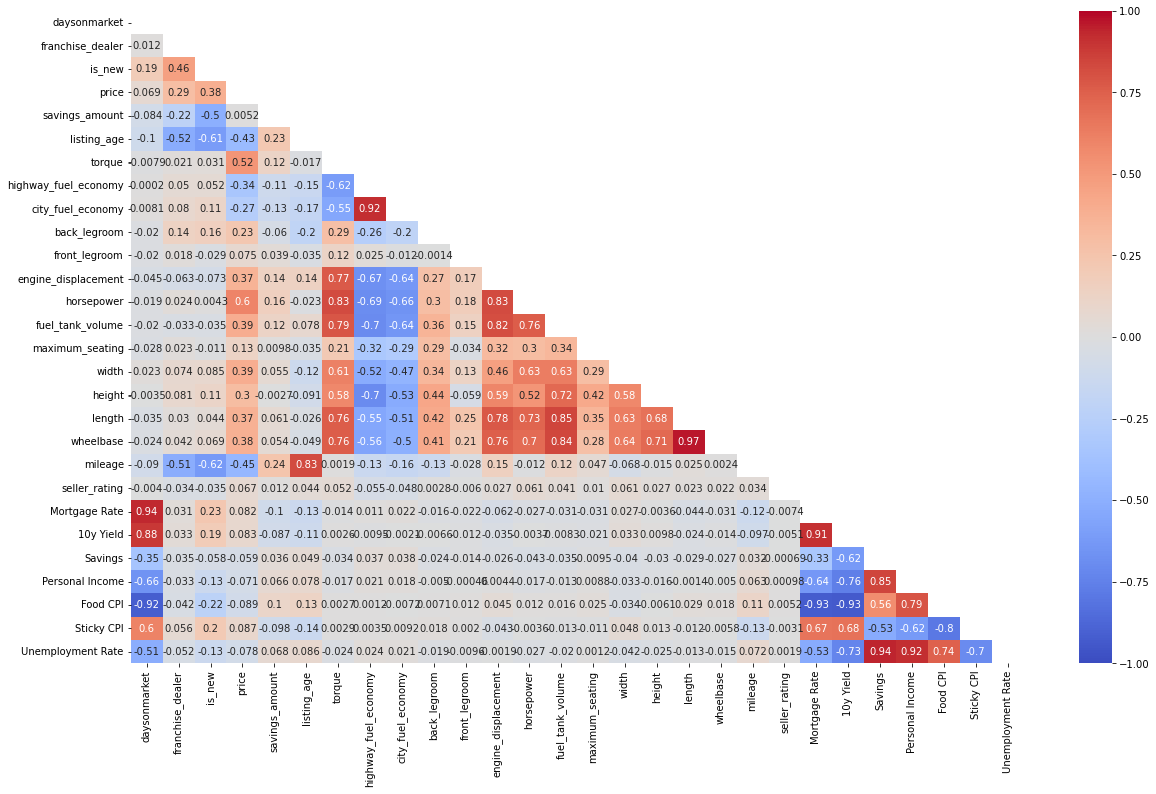

In [55]:
plt.figure(figsize=(20,12))
mask = np.triu(np.ones_like(df_final.corr(), dtype= bool))
sns.heatmap(df_final.corr(), annot=True, cmap='coolwarm', mask=mask,vmin=-1, vmax=1);

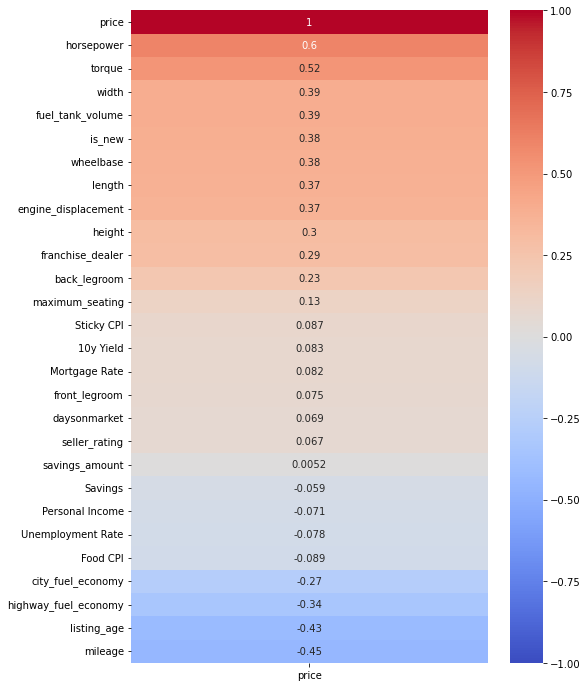

In [56]:
plt.figure(figsize=(8, 12))
sns.heatmap(df_final.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm');

In [57]:
cols_numeric = df_final.select_dtypes(include=np.number).columns.tolist()[:19]

<Figure size 1440x432 with 0 Axes>

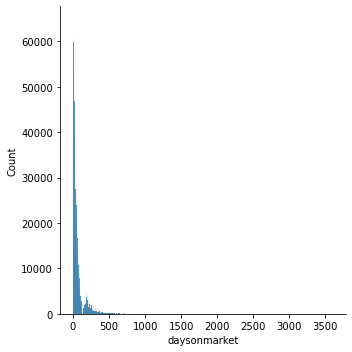

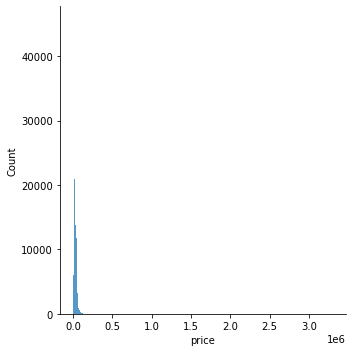

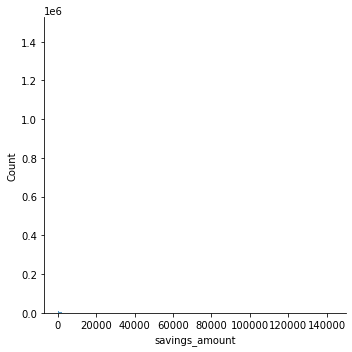

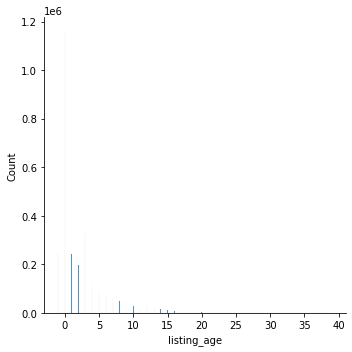

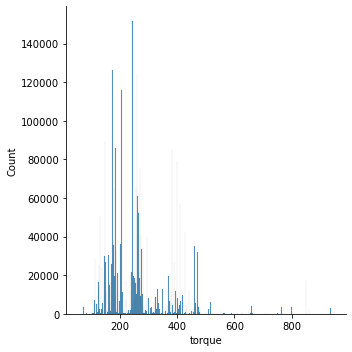

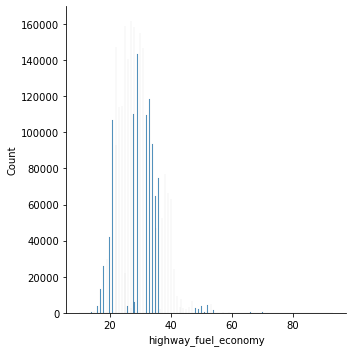

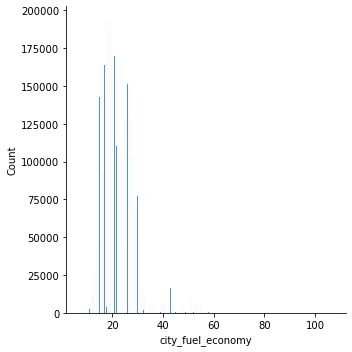

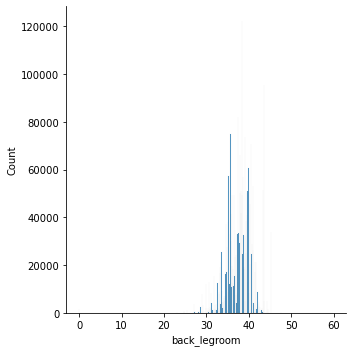

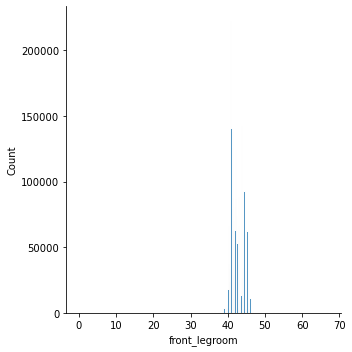

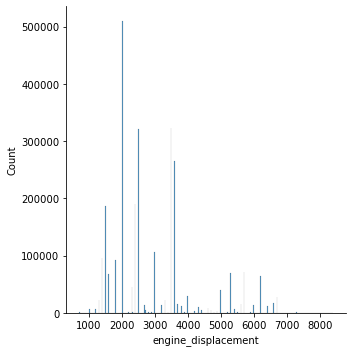

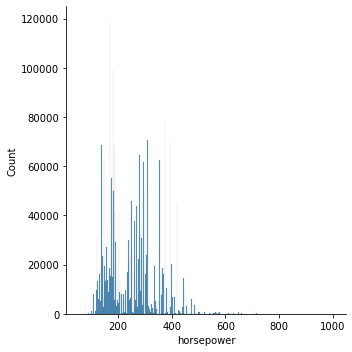

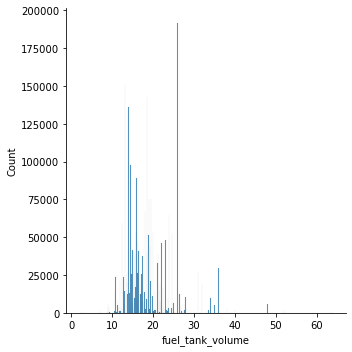

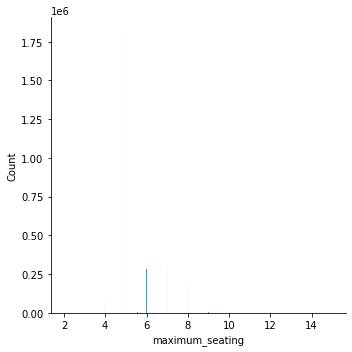

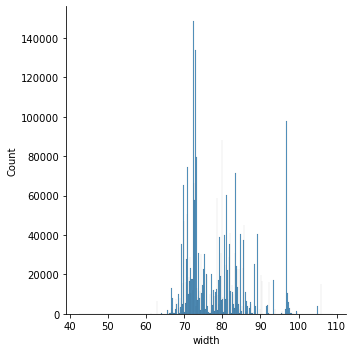

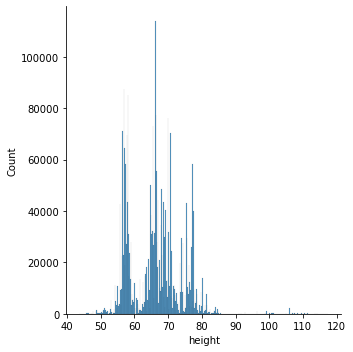

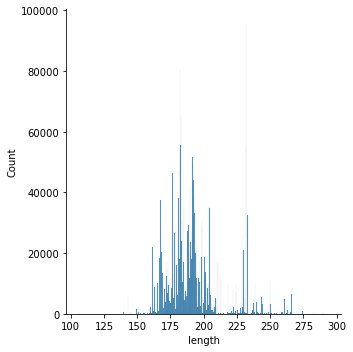

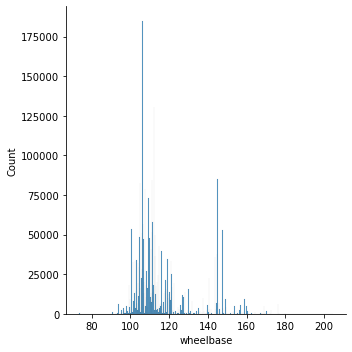

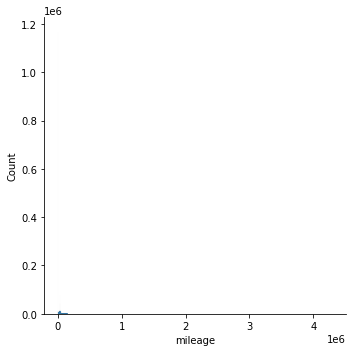

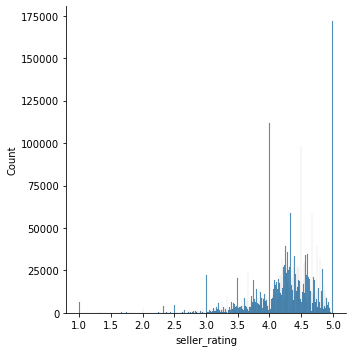

In [58]:
plt.figure(figsize=(20,6))
for col in cols_numeric:
    sns.displot(df_final[col])

In [59]:
#There are probably outliers in the data, but will worry about that in the second run
#Prefer to get a baseline

In [59]:
del(df_car)
del(df_na_lookup)
del(df_car_final)
gc.collect()

2327672

## Model

In [60]:
df_model = pd.get_dummies(df_final)

In [61]:
X = df_model.drop('price', axis=1)
Y = df_model['price']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### Linear Regression

In [62]:
linear_reg = LinearRegression()

In [63]:
linear_reg.fit(X_train,y_train)

LinearRegression()

In [64]:
y_pred = linear_reg.predict(X_test)

In [65]:
#RMSE
print(np.sqrt(mean_squared_error(y_test,y_pred)))

9580.61037930437


In [66]:
#R^2
r2_score(y_test,y_pred)

0.7358812140751565

### Random Forest

In [67]:
rf = RandomForestRegressor(n_estimators=100)

In [68]:
rf.fit(X_train,y_train)

RandomForestRegressor()

In [69]:
rf_y_pred = rf.predict(X_test)

In [70]:
#RMSE
print(np.sqrt(mean_squared_error(y_test,rf_y_pred)))

4601.499229983601


In [71]:
#R^2
r2_score(y_test,rf_y_pred)

0.939072740779828

In [72]:
rf.feature_importances_[:20]

array([0.00652343, 0.00058498, 0.00472147, 0.00758352, 0.19754976,
       0.0216547 , 0.00544686, 0.02877618, 0.00700833, 0.00313934,
       0.01893256, 0.458111  , 0.01252081, 0.00699986, 0.01616062,
       0.03028712, 0.00811288, 0.01273871, 0.04388605, 0.00894296])

Text(0.5, 0, 'Random Forest Feature Importance')

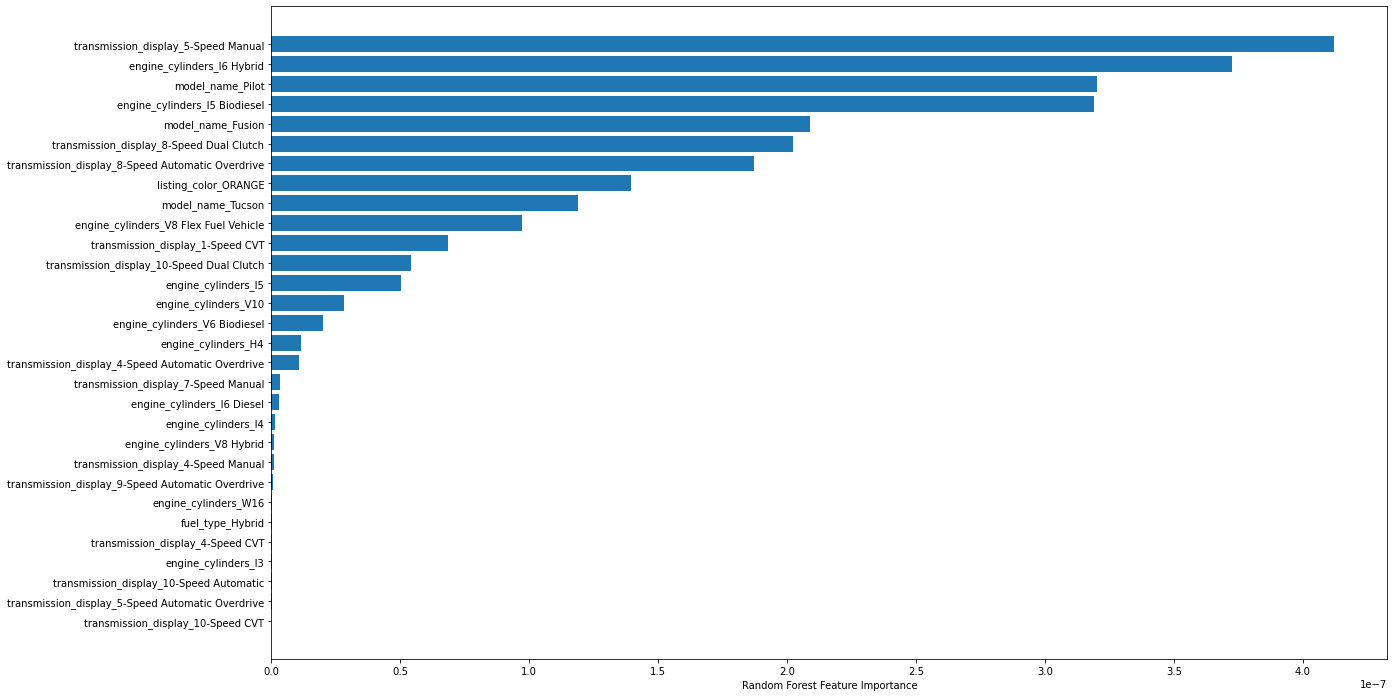

In [75]:
#Built in Feature Importance
plt.figure(figsize=(20,12))
sorted_idx = rf.feature_importances_.argsort()[:30]
plt.barh(df_model.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
perm_importance = permutation_importance(rf, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

In [ ]:
plt.barh(df_model.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")